# 简介

本项目来源于共创计划开发性课题CAE领域的基于飞桨+DeepXDE/PaddleScience的复杂结构受力分析。深度学习擅长数据驱动，而工程结构有各种控制方程，PINN（Physics-informed Neural Network）方法利用控制方程加速深度学习神经网络收敛，甚至在无训练数据的情况下实现无监督学习。

板是工程结构中常见构件，板控制方程存在高阶微分，这个问题的解决可以为后续解决复杂结构问题打下良好基础。从标准教科书中可以获得薄板小挠度理论的基本方程以及相关的边界条件表达式，教科书可参考《钱伟长，叶开沅，弹性力学，科学出版社，1956》。

薄板小挠度理论的基本方程为：$\frac{\partial^4 w}{\partial x^4}+2 \frac{\partial^4 w}{\partial x^2 \partial y^2}+\frac{\partial^4 w}{\partial y^4}=\frac{q}{D}$，其中D薄板弯曲刚度，q垂直板中面的分布载荷。

薄板x方向长2m，y方向宽1m，板厚10mm，x方向左右两边简支，y方向上下两边自由。

左右两边 $(x=-1 \mid x=+1)$ 为简支边界条件, 挠度和弯矩都为 0 :

$$
(w)_{x=-1 \mid x=+1}=0, \quad\left(M_x\right)_{x=-1 \mid x=+1}=0
$$


由于 $M_x=-D\left(\frac{\partial^2 w}{\partial x^2}+\mu \frac{\partial^2 w}{\partial y^2}\right)$, 且 $\frac{\partial^2 w}{\partial y^2}=0$, 所以简支边界条件用挠度表示为

$$
(w)_{x=-1 \mid x=+1}=0, \quad\left(\frac{\partial^2 w}{\partial x^2}\right)_{x=-1 \mid x=+1}=0
$$


上下两边 $(y=-0.5 \mid y=+0.5)$ 为自由边界条件, 弯矩、扭矩、横向剪切力都为 0 :

$$
\left(M_y\right)_{\mathrm{y}=-0.5 \mid \mathrm{y}=+0.5}=0, \quad\left(M_{x y}\right)_{\mathrm{y}=-0.5 \mid \mathrm{y}=+0.5}=0, \quad\left(Q_y\right)_{\mathrm{y}=-0.5 \mid \mathrm{y}=+0.5}=0
$$


由于 $M_y=-D\left(\frac{\partial^2 w}{\partial y^2}+\mu \frac{\partial^2 w}{\partial x^2}\right), \quad M_{x y}=-D(1-\mu) \frac{\partial^2 w}{\partial x \partial y}, Q_y=-D \frac{\partial}{\partial y}\left(\frac{\partial^2 w}{\partial x^2}+\frac{\partial^2 w}{\partial y^2}\right)$ ，且扭矩可以变换为等效剪力, 扭矩和横向剪力合并为 $\left(Q_y+\frac{\partial M_{x y}}{\partial x}\right)_{\mathrm{y}=-0.5 \mid \mathrm{y}=+0.5}=0$, 所以自由边界条件用挠度表示为

$$
\left(\frac{\partial^2 w}{\partial y^2}+\mu \frac{\partial^2 w}{\partial x^2}\right)_{y=-0.5 \mid y=+0.5}=0, \quad\left(\frac{\partial^3 w}{\partial y^3}+(2-\mu) \frac{\partial^3 w}{\partial x^2 \partial y}\right)_{y=-0.5 \mid y=+0.5}=0
$$


## 1. 设置计算域

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import ppsci
import sympy as sp
import numpy as np

# 设置薄板计算域长、宽参数
Lx = 2.0
Ly = 1.0
# 设置方程参数
E = 210000.0e6
mu = 0.28
h = 0.01
D = E * (h**3) / (12 * (1 - mu**2))
q = 1000.0

rectangle = ppsci.geometry.Rectangle([-Lx / 2, -Ly / 2], [Lx / 2, Ly / 2])

## 2. 编写矩形薄板挠曲方程残差

In [2]:
# 使用sympy编写
x, y = sp.symbols("x y")
w = sp.Function("w")(x, y)
left = w.diff(x, 4) + 2 * w.diff(x, 2).diff(y, 2) + w.diff(y, 4)
right = q / D
res = left - right

## 3. 初始化神经网络模型

In [3]:
model = ppsci.arch.MLP(["x", "y"], ["w"], 4, 50)

W1029 15:20:08.278719 12171 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.6
W1029 15:20:08.292644 12171 gpu_resources.cc:164] device: 0, cuDNN Version: 8.4.


## 4. 初始化控制方程和边界条件

In [4]:

pde_contraint = ppsci.constraint.InteriorConstraint(
    {"kirchhoff_res": res},
    {"kirchhoff_res": 0.0},
    rectangle,
    {
        "dataset": "IterableNamedArrayDataset",
        "iters_per_epoch": 1,
        "batch_size": 20000,
    },
    loss=ppsci.loss.MSELoss(),
)

constraint_left_right = ppsci.constraint.BoundaryConstraint(
    {"w": w, "ddw_dxx": w.diff(x, 2)},
    {"w": 0.0, "ddw_dxx": 0.0},
    rectangle,
    {
        "dataset": "IterableNamedArrayDataset",
        "iters_per_epoch": 1,
        "batch_size": 10000,
    },
    criteria=lambda x, y: np.isclose(x, -Lx / 2) | np.isclose(x, Lx / 2),
    loss=ppsci.loss.MSELoss(),
)

constraint_up_down = ppsci.constraint.BoundaryConstraint(
    {
        "shearForce": w.diff(y, 2) + mu * w.diff(x, 2),
        "moment": w.diff(y, 3) + (2 - mu) * w.diff(x, 2).diff(y),
    },
    {"shearForce": 0.0, "moment": 0.0},
    rectangle,
    {
        "dataset": "IterableNamedArrayDataset",
        "iters_per_epoch": 1,
        "batch_size": 10000,
    },
    criteria=lambda x, y: np.isclose(y, -Ly / 2) | np.isclose(y, Ly / 2),
    loss=ppsci.loss.MSELoss(),
)

[2024/10/29 15:20:13] ppsci WARNING: Logger has already been automatically initialized as `log_file` is set to None by default, information will only be printed to terminal without writting to any file.


## 5. 初始化求解器并开始求解

In [5]:
# set optimizer
opt = ppsci.optimizer.LBFGS(max_iter=1000)(model)
solver = ppsci.solver.Solver(
    model,
    {
        "pde_contraint": pde_contraint,
        "constraint_left_right": constraint_left_right,
        "constraint_up_down": constraint_up_down,
    },
    output_dir="./output_kirchhoff",
    optimizer=opt,
    epochs=400,
    iters_per_epoch=1,
    log_freq=50,
    # pretrained_model_path="./output_kirchhoff/checkpoints/latest"
)
solver.train()

[2024/10/29 15:20:13] ppsci INFO: Using paddlepaddle 2.6.1 on device Place(gpu:0)
[2024/10/29 15:20:13] ppsci MESSAGE: Set to_static=False for computational optimization.
[2024/10/29 15:21:12] ppsci INFO: [Train][Epoch   1/400][Iter 1/1] lr: 1.00000, loss: 0.00000, pde_contraint: 0.00000, constraint_left_right: 0.00000, constraint_up_down: 0.00000, batch_cost: 59.32593s, reader_cost: 0.00001s, ips: 674.24, eta: 6:34:31
[2024/10/29 15:21:12] ppsci MESSAGE: Finish saving checkpoint to: ./output_kirchhoff/checkpoints/latest(latest checkpoint will be saved every epoch as expected, but this log will be printed only once for tidy logging)
[2024/10/29 15:21:24] ppsci INFO: [Train][Epoch  50/400][Iter 1/1] lr: 1.00000, loss: 0.00000, pde_contraint: 0.00000, constraint_left_right: 0.00000, constraint_up_down: 0.00000, batch_cost: 0.20123s, reader_cost: 0.00002s, ips: 198774.32, eta: 0:01:10
[2024/10/29 15:21:37] ppsci INFO: [Train][Epoch 100/400][Iter 1/1] lr: 1.00000, loss: 0.00000, pde_contra

## 6. 结果可视化

num_cords = 10201
(10201,) (10201,) (10201, 1)


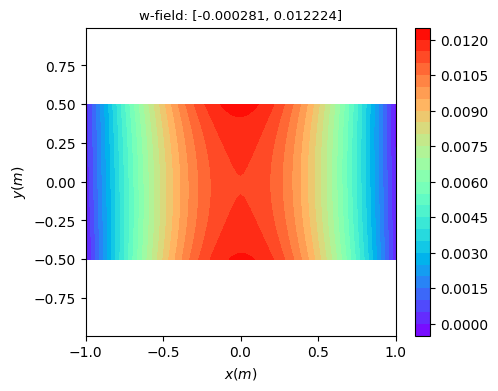

In [6]:
# plot result
num_cord0 = 101
num_cord1 = 101
num_cords = num_cord0 * num_cord1
print(f"num_cords = {num_cords}")
x, y = np.meshgrid(
    np.linspace(
        start=-Lx / 2, stop=Lx / 2, num=num_cord0, endpoint=True, dtype="float32"
    ),
    np.linspace(
        start=-Ly / 2, stop=Ly / 2, num=num_cord1, endpoint=True, dtype="float32"
    ),
)
x = x.ravel()
y = y.ravel()
# predict solution of w(x, y) on the 2D grid
w_pred = solver.predict({"x": x[:, None], "y": y[:, None]}, return_numpy=True)["w"]
fig = plt.figure(100, figsize=(5, 4))
y_min = w_pred.min(axis=(0,))[0]
y_max = w_pred.max(axis=(0,))[0]
ax1 = plt.subplot(1, 1, 1)
plt.tricontourf(x, y, w_pred[:, 0], levels=30, cmap="rainbow")
print(x.shape, y.shape, w_pred.shape)
cb1 = plt.colorbar()
plt.axis("equal")
plt.xlabel("$x (m)$")
plt.ylabel("$y (m)$")
plt.title(f"w-field: [{y_min:.6f}, {y_max:.6f}]", fontsize=9.5)
plt.show()
# plt.savefig("./result.jpg")
# print("saved matplotlib to: ./result.jpg")

## 7.有限元计算结果比较

通过比较，可以发现PINN方法计算结果和有限元方法计算结果完全一致。这里有限元计算所用薄板的几何参数、材料参数、载荷及边界条件和第2部分所描述薄板是一样的，有限元计算所用软件为SIPESC2022。PINN方法计算的最大挠度是12.2mm，有限元方法计算的最大挠度是12.2mm，两者的计算结果相差很小。
<img src="./FEM.png" alt="FEM_result" width="60%">
